In [1]:
import torch
import pandas as pd
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt

In [2]:
from nselib import capital_market

In [3]:
Nifty_50_datadf=capital_market.index_data('NIFTY 50',from_date='01-09-2024',to_date='05-02-2025')
Nifty_50_data = Nifty_50_datadf.to_numpy()

In [4]:
closeIndex=Nifty_50_datadf.columns.get_loc('CLOSE_INDEX_VAL')
min_Close_Value=min(Nifty_50_data[:,4])
max_for_Normalisation=30000

In [5]:
import numpy as np

<h3>Scaled Data</h3>

In [6]:
def scaleFormula(dayData, min , max):
    return  (dayData-min)/(max-min)

In [7]:
def unscaleFormula(scaledData, min, max):
    return scaledData*(max-min)+min

In [8]:
def NpScaleFormula(dataset,min,max):
    for i in range(len(dataset)):
        dataset[i]=scaleFormula(dataset[i],min=min,max=max)
    return dataset

In [9]:
Scaled_Nifty_50_data=[]
for dayData in Nifty_50_data:
    Scaled_Nifty_50_data.append([dayData[0],scaleFormula(dayData=dayData[4],min=min_Close_Value,max=max_for_Normalisation)])
Scaled_Nifty_50_data

[['02-09-2024', 0.34159827635496487],
 ['02-09-2024', 0.34159827635496487],
 ['03-09-2024', 0.3417586478590401],
 ['04-09-2024', 0.3304419978105803],
 ['05-09-2024', 0.32296729118584233],
 ['06-09-2024', 0.28211439369112457],
 ['09-09-2024', 0.29386334953317955],
 ['10-09-2024', 0.3084641290781424],
 ['11-09-2024', 0.29136015953478317],
 ['12-09-2024', 0.3569660500498547],
 ['13-09-2024', 0.35244775723937877],
 ['16-09-2024', 0.35624786461855973],
 ['17-09-2024', 0.36110084578536694],
 ['18-09-2024', 0.3553832530313698],
 ['19-09-2024', 0.3607173487104037],
 ['20-09-2024', 0.41303332240947727],
 ['23-09-2024', 0.433686383064769],
 ['24-09-2024', 0.43387464526520575],
 ['25-09-2024', 0.4427648047302622],
 ['26-09-2024', 0.47231499752470046],
 ['27-09-2024', 0.46714127334974237],
 ['30-09-2024', 0.4158084466973926],
 ['01-10-2024', 0.41386307062621597],
 ['03-10-2024', 0.3376099067753471],
 ['04-10-2024', 0.304768611810315],
 ['07-10-2024', 0.2742492173173332],
 ['08-10-2024', 0.30456640

<h3>Length of training and testing </h3>

In [10]:
Train_Size=int(len(Nifty_50_data)*0.75)
Test_Size=len(Nifty_50_data)-Train_Size
print(Train_Size,Test_Size)

83 28


<h3>Creating DataSet</h3>

In [11]:
def Create_TimeSeries_Dataset(seq_length,dataset):
    dataX, dataY=[],[]
    for i in range(len(dataset)-seq_length-1):
        a = dataset[i:(i+seq_length)]
        dataX.append(a)
        dataY.append(dataset[i+seq_length])
    return np.array(dataX) , np.array(dataY)

In [12]:
# Non_Scaled_TrainX, Non_Scaled_TrainY= Create_TimeSeries_Dataset(5,Nifty_50_data[:,4])
Scaled_Nifty_50_data=np.array(Scaled_Nifty_50_data)
Scaled_Nifty_50_data[:, 0] = Scaled_Nifty_50_data[:, 0].astype(str)
fdata =np.array(Scaled_Nifty_50_data[:, 1], dtype=float)
Scaled_Nifty_50_data[:,1]=fdata

TrainX,TrainY=Create_TimeSeries_Dataset(15,fdata[:Train_Size])
TestX,TestY=Create_TimeSeries_Dataset(15,fdata[Train_Size:])

<h3>Reshaping the data to fit in LSTM (batchsize, timesteps ,feature)</h3>

In [13]:
#later we will add another feature which will have the probabilty of the market sentiment ,3dim, for now feature is 1 dim
TrainX=TrainX.reshape(TrainX.shape[0], TrainX.shape[1],1)
TestX=TestX.reshape(TestX.shape[0], TestX.shape[1],1)

<h2> LSTM model making</h2>

In [14]:
TrainX.shape

(67, 15, 1)

In [15]:
import tensorflow as tf

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM ,Input

In [17]:
n_steps=15
n_features=1

In [18]:
model = Sequential()
model.add( Input(shape=(n_steps, n_features)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(150,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 15, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 15, 150)        │       120,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,251 (668.95 KB)

 Trainable params: 171,251 (668.95 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model.fit(TrainX, TrainY, validation_data=(TestX,TestY), epochs=95,batch_size=5, verbose=1 )

Epoch 1/95
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0371 - val_loss: 0.0042
Epoch 2/95
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0050 - val_loss: 0.0071
Epoch 3/95
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0058 - val_loss: 0.0078
Epoch 4/95
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0060 - val_loss: 0.0039
Epoch 5/95
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0060 - val_loss: 0.0031
Epoch 6/95
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0054 - val_loss: 0.0054
Epoch 7/95
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0053 - val_loss: 0.0083
Epoch 8/95
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0051 - val_loss: 0.0037
Epoch 9/95
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0054 - val_loss: 0.0028
Epoch 10/95
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0059 - val_loss: 0.0039
Epoch 11/95
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0046 - val_loss: 0.0038
Epoch 12/95
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0

<h3>Prediction</h3>

In [20]:
train_predict=model.predict(TrainX)
test_predict=model.predict(TestX)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


<h5>Converting to original value/price</h5>

In [21]:
def NpUnscaleFormula(dataset,min,max):
    for i in range(len(dataset)):
        dataset[i]=unscaleFormula(dataset[i],min=min,max=max)
    return dataset

In [22]:
UnScaled_train_predict=NpUnscaleFormula(train_predict.copy(),min_Close_Value,max_for_Normalisation)
UnScaled_test_predict=NpUnscaleFormula(test_predict.copy(),min_Close_Value,max_for_Normalisation)
UnScaled_TrainX=NpUnscaleFormula(TrainX.copy(),min_Close_Value,max_for_Normalisation)
UnScaled_TrainY=NpUnscaleFormula(TrainY.copy(),min_Close_Value,max_for_Normalisation)
UnScaled_TestY=NpUnscaleFormula(TestY.copy(),min_Close_Value,max_for_Normalisation)

In [23]:
UnScaled_test_predict[-1]

array([23690.67], dtype=float32)

In [24]:
input_last_15_days=capital_market.index_data('NIFTY 50',from_date='17-01-2025',to_date='05-02-2025')

In [25]:
input_last_15_days=np.array(input_last_15_days)
Scaled_input15days=NpScaleFormula(input_last_15_days[:,4].copy(),min_Close_Value,max_for_Normalisation)
Scaled_input15days = Scaled_input15days.astype(np.float32)
Scaled_input15days=Scaled_input15days.reshape(1,Scaled_input15days.shape[0],1)
print(Scaled_input15days.dtype)

PredictedPrice=model.predict(Scaled_input15days)
PredictedPrice=NpUnscaleFormula(PredictedPrice,min_Close_Value,max_for_Normalisation)
print(PredictedPrice)

float32
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[[23918.867]]


In [26]:
future_days=15
DataX=Scaled_input15days.copy()
print(DataX.shape)
DataY=[]
for i in range(future_days):
    # DataX=DataX.reshape(1,DataX.shape[1],1)
    prediction=model.predict(DataX)
    print(unscaleFormula(prediction[0].copy(),min_Close_Value, max_for_Normalisation))
    DataY.append(unscaleFormula(prediction[0].copy(),min_Close_Value, max_for_Normalisation))
    prediction_reshaped = prediction[0].reshape(1, 1, 1)  
    DataX = DataX[:,1:,:]
    DataX = np.append(DataX, prediction_reshaped, axis=1)


(1, 15, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[23918.867]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[24048.643]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[24182.26]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[24302.92]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[24410.69]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[24504.732]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[24583.14]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[24643.387]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[24685.1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[24707.574]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[24710.955]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
[24696.957]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[24668.01]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[24628.4]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[24582.355]


<h2>Plotting</h2>

In [27]:
from matplotlib import pyplot 

           0
0   25790.95
1   25939.05
2    25940.4
3   26004.15
4   26216.05
..       ...
91   23508.4
92  23482.15
93  23361.05
94  23739.25
95   23696.3

[96 rows x 1 columns]


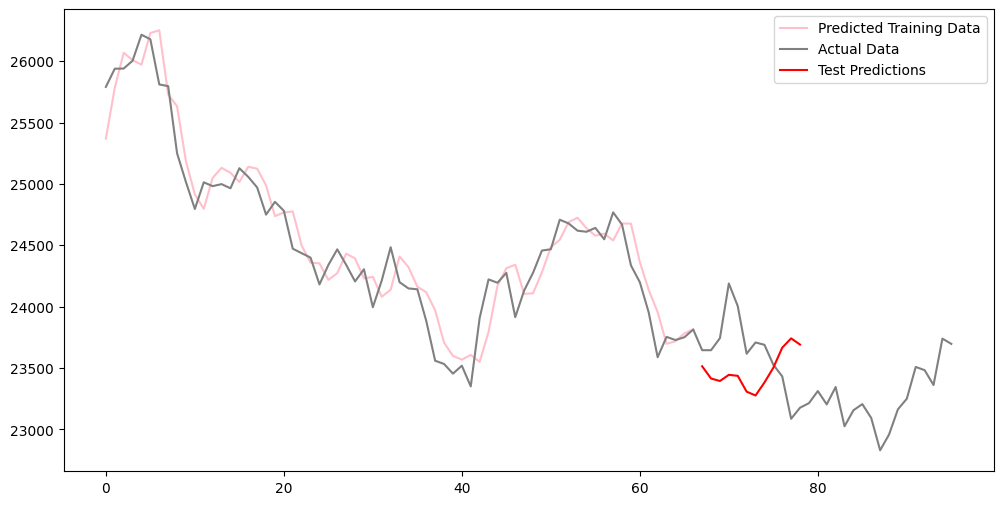

In [28]:
dfAct= pd.DataFrame(Nifty_50_data[15:,4])
df1 = pd.DataFrame(UnScaled_train_predict)
df2 = pd.DataFrame(UnScaled_test_predict)
df3_real = pd.DataFrame(UnScaled_TestY)
print(dfAct)
train_length = len(df1)
test_length = len(df2)

plt.figure(figsize=(12, 6))  # Set figure size

# Plot training predictions (pink)
plt.plot(range(train_length), df1.values.flatten(), color='pink', label="Predicted Training Data")
plt.plot( dfAct, color='gray', label="Actual Data")

# Plot test predictions (red) with shifted x-axis
plt.plot(range(train_length, train_length + test_length), df2.values.flatten(), color='red', label="Test Predictions")

# Plot actual test values (black) with shifted x-axis

plt.legend()
plt.show()
